**Load the Library and Dataset**

The first step we need to do as a starting point is to load the library and the dataset.

In [1]:
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


Here, we will see some of the examples of our bird image dataset.

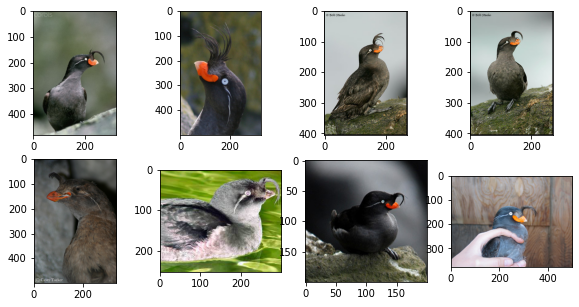

In [3]:
src_path = "/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/CUB_200_2011/images/005.Crested_Auklet"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path, sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [4]:
# Implementing A Training Script
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import InceptionV3
from keras.models import Model
from keras.optimizers import Adam, SGD

**Creating A Dataframe**

There are 4 txt files we need to read to create a dataframe that will help us to create the generator as an input for our model later. We also create the columns for the txt files we read and join them into one dataframe altogether. 

In [5]:
train_test_data_path = '/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/CUB_200_2011/train_test_split.txt'
train_test_data = pd.read_csv(train_test_data_path, delim_whitespace=True, header=None)
train_test_data.columns = ['image_id', 'is_training_image']

images_path = '/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/CUB_200_2011/images.txt'
images = pd.read_csv(images_path, delim_whitespace=True, header=None)
images.columns = ['image_id', 'filename']

class_label_path = '/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/CUB_200_2011/image_class_labels.txt'
class_label = pd.read_csv(class_label_path, delim_whitespace=True, header=None)
class_label.columns = ['image_id', 'class_id']

classes_path = '/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/CUB_200_2011/classes.txt'
classes= pd.read_csv(classes_path, delim_whitespace=True, header=None)
classes.columns = ['class_id', 'class_label']

df1 = class_label.join(train_test_data.set_index('image_id'), on='image_id')
df2 = df1.join(images.set_index('image_id'), on='image_id')
all_df = df2.join(classes.set_index('class_id'), on='class_id')
all_df

,image_id,class_id,is_training_image,filename,class_label
0,1,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
1,2,1,1,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
2,3,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
3,4,1,1,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
4,5,1,1,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
...,...,...,...,...,...
11783,11784,200,1,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat
11784,11785,200,0,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat
11785,11786,200,0,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat
11786,11787,200,1,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat


As we can see below, there are 200 classes of birds that our model should predict later on.

In [6]:
classes

,class_id,class_label
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross
2,3,003.Sooty_Albatross
3,4,004.Groove_billed_Ani
4,5,005.Crested_Auklet
...,...,...
195,196,196.House_Wren
196,197,197.Marsh_Wren
197,198,198.Rock_Wren
198,199,199.Winter_Wren


**Splitting The Dataset**

Our model needs train, validation and test datasets. Therefore, we need to split the dataset we've created into three datasets for our experiment purposes. The training image is identified by the value 1 in the column called **"is_training_image"**. For validation purposes, we'll split the training set with the probability of 25% because if it's less, my generator will only get less tahn 200 classes using train_test_split. 

I also tried using validation_split of the image generator with the probability of 10% and got 200 classes for the validation generator. But it affects the accuracy score. It didn't reach 50%. 

In [7]:
import random

train_valid_df = all_df[all_df['is_training_image'] == 1]
test_df = all_df[all_df['is_training_image'] ==  0]


train_valid_df_new = train_valid_df.sample(frac=1, random_state=46)

train_df, valid_df = train_test_split(train_valid_df_new, test_size=0.25, random_state=42)

In [8]:
train_df

,image_id,class_id,is_training_image,filename,class_label
8785,8786,150,1,150.Sage_Thrasher/Sage_Thrasher_0079_155718.jpg,150.Sage_Thrasher
7338,7339,126,1,126.Nelson_Sharp_tailed_Sparrow/Nelson_Sharp_T...,126.Nelson_Sharp_tailed_Sparrow
3458,3459,60,1,060.Glaucous_winged_Gull/Glaucous_Winged_Gull_...,060.Glaucous_winged_Gull
10771,10772,183,1,183.Northern_Waterthrush/Northern_Waterthrush_...,183.Northern_Waterthrush
1591,1592,29,1,029.American_Crow/American_Crow_0003_25130.jpg,029.American_Crow
...,...,...,...,...,...
6456,6457,111,1,111.Loggerhead_Shrike/Loggerhead_Shrike_0007_1...,111.Loggerhead_Shrike
5171,5172,89,1,089.Hooded_Merganser/Hooded_Merganser_0036_796...,089.Hooded_Merganser
7885,7886,135,1,135.Bank_Swallow/Bank_Swallow_0003_129623.jpg,135.Bank_Swallow
2245,2246,40,1,040.Olive_sided_Flycatcher/Olive_Sided_Flycatc...,040.Olive_sided_Flycatcher


In [9]:
valid_df

,image_id,class_id,is_training_image,filename,class_label
1922,1923,34,1,034.Gray_crowned_Rosy_Finch/Gray_Crowned_Rosy_...,034.Gray_crowned_Rosy_Finch
10112,10113,172,1,172.Nashville_Warbler/Nashville_Warbler_0098_1...,172.Nashville_Warbler
5041,5042,87,1,087.Mallard/Mallard_0077_75911.jpg,087.Mallard
7929,7930,136,1,136.Barn_Swallow/Barn_Swallow_0026_132386.jpg,136.Barn_Swallow
10560,10561,180,1,180.Wilson_Warbler/Wilson_Warbler_0129_175256.jpg,180.Wilson_Warbler
...,...,...,...,...,...
3763,3764,65,1,065.Slaty_backed_Gull/Slaty_Backed_Gull_0053_7...,065.Slaty_backed_Gull
9664,9665,165,1,165.Chestnut_sided_Warbler/Chestnut_Sided_Warb...,165.Chestnut_sided_Warbler
3388,3389,59,1,059.California_Gull/California_Gull_0105_41116...,059.California_Gull
10574,10575,180,1,180.Wilson_Warbler/Wilson_Warbler_0107_175320.jpg,180.Wilson_Warbler


In [10]:
test_df

,image_id,class_id,is_training_image,filename,class_label
0,1,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
2,3,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
5,6,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
9,10,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
11,12,1,0,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross
...,...,...,...,...,...
11779,11780,200,0,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat
11782,11783,200,0,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat
11784,11785,200,0,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat
11785,11786,200,0,200.Common_Yellowthroat/Common_Yellowthroat_00...,200.Common_Yellowthroat


**Creating An Image Generator**

The next step is to create an image generator. We only rescale the image as we'll use the pretrained model called Inception V3. Our model is better with normalization. I also tried to apply some of the preprocessed technique such as rotating the images, flipping, etc. But it affected the accuracy score quite badly which didn't reach even 1%. 

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

src_path = "/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/CUB_200_2011/images/"

# normalize to scale between 0 and 1
imdatagen = ImageDataGenerator(
    rescale=1/255,
    # rotation_range=20,
    # zoom_range=20,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    # shear_range=0.05,
    # horizontal_flip=True,
    # fill_mode="nearest"
)

The next step is we need to create the generators using the image data generator we defined. 

In [12]:
import math
import numpy as np

batch_size = 64

train_generator = imdatagen.flow_from_dataframe(
    dataframe=train_df,
    directory=src_path,
    x_col="filename",
    y_col="class_label",
    target_size=(300,300),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42,
    color_mode='rgb',
)

validation_generator = imdatagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=src_path,
    x_col="filename",
    y_col="class_label",
    target_size=(300,300),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    color_mode='rgb',
    # subset="validation"
)

test_generator = imdatagen.flow_from_dataframe(
    dataframe=test_df,
    directory=src_path,
    x_col="filename",
    y_col="class_label",
    target_size=(300,300),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 4495 validated image filenames belonging to 200 classes.
Found 1499 validated image filenames belonging to 200 classes.
Found 5794 validated image filenames belonging to 200 classes.


In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
import tensorflow as tf

print('Keras version:', keras.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Keras version: 2.11.0
Num GPUs Available:  1


In [14]:
# Function used to plot the curves for loss and accuracy:
def plot_curves(history):

  # Plotting the loss curve:
  plt.subplot(211)
  plt.title('Cross Entropy')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # Plotting the training loss (blue):
  plt.plot(history.history['loss'], color='blue', label='train')
  # Plotting the test loss (red):
  plt.plot(history.history['val_loss'], color='red', label='test')
  # Legend for the plot:
  plt.legend(['train', 'test'], loc='upper left')

  # Plotting the accuracy curve:
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  # Plotting the training accuracy (blue):
  plt.plot(history.history['accuracy'], color='blue', label='train')
  # Plotting the test accuracy (red):
  plt.plot(history.history['val_accuracy'], color='red', label='test')
  # Legend for the plot:
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplots_adjust(top=3)
  plt.show()

print('Done!')

Done!


In [15]:
import sklearn.metrics as metrics

# Function to plot the confusion matrix:
def plot_confusion_matrix(gt, pred, classes=0, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    cm = metrics.confusion_matrix(gt, pred)
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, fontsize=3)
    plt.yticks(tick_marks, fontsize=3)

    plt.grid(True)

    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.tight_layout()
    plt.savefig(f"cm.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

We'll try to reduce little by little the learning rate to see the improvement in every epoch. 

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-4
    elif epoch > 30:
        lr *= 1e-4
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-2
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

**Creating the Model**

We'll try to use Inception V3 for our dataset as I've tried VGG16 and Resnet 50 which didn't give scores above 50%. Inception V3 has proved to be computationally efficient in he number of parameters and computational cost (memory and other resources). 

Here are the steps in Inception V3:
1. Factorized Convolutions: helps to reduce the computational efficiency by reducing the number of parameters in a network.
2. Smaller Convolutions: substitutes bigger convolutions with smaller convolutions which makes the training faster. Let's say a 5 × 5 filter has 25 parameters; two 3 × 3 filters replacing a 5 × 5 convolution has only 18 (3*3 + 3*3) parameters instead.
3. Asymmetric convolutions: A 3 × 3 convolution could be replaced by a 1 × 3 convolution followed by a 3 × 1 convolution. If a 3 × 3 convolution is replaced by a 2 × 2 convolution, the number of parameters is slightly higher than the asymmetric convolution.
4. Auxiliary classifier: a small CNN inserted between layers during training, and the loss is added to the main network loss. It acts as a regularizer.
5. Grid size reduction:  helps to combat the bottlenecks of computational cost, even though it's normally done by pooling operations.



In [17]:
# Creating the model
# This function defines our neural network:

IMG_SIZE = 300
num_classes = 200

base_model = InceptionV3(weights = 'imagenet', include_top = False) 

# for layer in base_model.layers:
#     layer.trainable = False
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.7)(x)
x = Dense(512, activation = 'tanh')(x) 
x = Dense(num_classes, activation = 'softmax')(x)  

model = Model(inputs = base_model.input, outputs = x)

# The model optimises cross entropy as its loss function and will monitor classification accuracy:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')

# Printing model summary:
print(model.summary())

87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

We also create the early stopping if the validation loss decreases for 3 times. It can help us to prevent the accuracy score decreases more. 

In [18]:
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 

**Fitting the Model**

In [19]:
checkpoint_filepath = "/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

model_filepath = "/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_path_fixed"
tf.keras.models.save_model(
    model,
    model_filepath
)

history = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=30,
                    callbacks=[lr_scheduler, early_stopping, model_checkpoint_callback],
                    verbose=2,
                    shuffle=False,
                    validation_data = validation_generator
)

Learning rate:  0.001
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.50510, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 3455s - loss: 4.6965 - accuracy: 0.0732 - val_loss: 3.5051 - val_accuracy: 0.1928 - lr: 0.0010 - 3455s/epoch - 49s/step
Learning rate:  0.001
Epoch 2/30

Epoch 2: val_loss improved from 3.50510 to 2.74554, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 3.2346 - accuracy: 0.2400 - val_loss: 2.7455 - val_accuracy: 0.3169 - lr: 0.0010 - 65s/epoch - 921ms/step
Learning rate:  0.001
Epoch 3/30

Epoch 3: val_loss improved from 2.74554 to 2.44318, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 2.6189 - accuracy: 0.3404 - val_loss: 2.4432 - val_accuracy: 0.3649 - lr: 0.0010 - 66s/epoch - 928ms/step
Learning rate:  0.001
Epoch 4/30

Epoch 4: val_loss improved from 2.44318 to 2.21651, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 2.2871 - accuracy: 0.4111 - val_loss: 2.2165 - val_accuracy: 0.4116 - lr: 0.0010 - 66s/epoch - 933ms/step
Learning rate:  0.001
Epoch 5/30

Epoch 5: val_loss improved from 2.21651 to 2.12169, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 2.0373 - accuracy: 0.4549 - val_loss: 2.1217 - val_accuracy: 0.4236 - lr: 0.0010 - 65s/epoch - 922ms/step
Learning rate:  0.001
Epoch 6/30

Epoch 6: val_loss improved from 2.12169 to 1.96351, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.9068 - accuracy: 0.4788 - val_loss: 1.9635 - val_accuracy: 0.4690 - lr: 0.0010 - 66s/epoch - 925ms/step
Learning rate:  0.001
Epoch 7/30

Epoch 7: val_loss improved from 1.96351 to 1.92521, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.7528 - accuracy: 0.5239 - val_loss: 1.9252 - val_accuracy: 0.4757 - lr: 0.0010 - 66s/epoch - 930ms/step
Learning rate:  0.001
Epoch 8/30

Epoch 8: val_loss improved from 1.92521 to 1.89785, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.6510 - accuracy: 0.5408 - val_loss: 1.8978 - val_accuracy: 0.4803 - lr: 0.0010 - 66s/epoch - 923ms/step
Learning rate:  0.001
Epoch 9/30

Epoch 9: val_loss improved from 1.89785 to 1.82248, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.5732 - accuracy: 0.5571 - val_loss: 1.8225 - val_accuracy: 0.4970 - lr: 0.0010 - 66s/epoch - 930ms/step
Learning rate:  0.001
Epoch 10/30

Epoch 10: val_loss improved from 1.82248 to 1.75672, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.4898 - accuracy: 0.5737 - val_loss: 1.7567 - val_accuracy: 0.5157 - lr: 0.0010 - 66s/epoch - 929ms/step
Learning rate:  0.001
Epoch 11/30

Epoch 11: val_loss improved from 1.75672 to 1.73176, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.4131 - accuracy: 0.5913 - val_loss: 1.7318 - val_accuracy: 0.5177 - lr: 0.0010 - 66s/epoch - 935ms/step
Learning rate:  1e-05
Epoch 12/30

Epoch 12: val_loss improved from 1.73176 to 1.70616, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2621 - accuracy: 0.6427 - val_loss: 1.7062 - val_accuracy: 0.5264 - lr: 1.0000e-05 - 65s/epoch - 920ms/step
Learning rate:  1e-05
Epoch 13/30

Epoch 13: val_loss improved from 1.70616 to 1.68415, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2793 - accuracy: 0.6352 - val_loss: 1.6841 - val_accuracy: 0.5357 - lr: 1.0000e-05 - 65s/epoch - 922ms/step
Learning rate:  1e-05
Epoch 14/30

Epoch 14: val_loss improved from 1.68415 to 1.66778, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2525 - accuracy: 0.6498 - val_loss: 1.6678 - val_accuracy: 0.5417 - lr: 1.0000e-05 - 65s/epoch - 918ms/step
Learning rate:  1e-05
Epoch 15/30

Epoch 15: val_loss improved from 1.66778 to 1.65580, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2358 - accuracy: 0.6621 - val_loss: 1.6558 - val_accuracy: 0.5457 - lr: 1.0000e-05 - 65s/epoch - 919ms/step
Learning rate:  1e-05
Epoch 16/30

Epoch 16: val_loss improved from 1.65580 to 1.64614, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2177 - accuracy: 0.6603 - val_loss: 1.6461 - val_accuracy: 0.5477 - lr: 1.0000e-05 - 65s/epoch - 918ms/step
Learning rate:  1e-05
Epoch 17/30

Epoch 17: val_loss improved from 1.64614 to 1.63959, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2025 - accuracy: 0.6632 - val_loss: 1.6396 - val_accuracy: 0.5470 - lr: 1.0000e-05 - 65s/epoch - 915ms/step
Learning rate:  1e-05
Epoch 18/30

Epoch 18: val_loss improved from 1.63959 to 1.63277, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2083 - accuracy: 0.6672 - val_loss: 1.6328 - val_accuracy: 0.5470 - lr: 1.0000e-05 - 65s/epoch - 915ms/step
Learning rate:  1e-05
Epoch 19/30

Epoch 19: val_loss improved from 1.63277 to 1.62825, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.1887 - accuracy: 0.6776 - val_loss: 1.6283 - val_accuracy: 0.5517 - lr: 1.0000e-05 - 66s/epoch - 925ms/step
Learning rate:  1e-05
Epoch 20/30

Epoch 20: val_loss improved from 1.62825 to 1.62559, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2098 - accuracy: 0.6670 - val_loss: 1.6256 - val_accuracy: 0.5504 - lr: 1.0000e-05 - 65s/epoch - 917ms/step
Learning rate:  1e-05
Epoch 21/30

Epoch 21: val_loss improved from 1.62559 to 1.62272, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.2025 - accuracy: 0.6627 - val_loss: 1.6227 - val_accuracy: 0.5524 - lr: 1.0000e-05 - 66s/epoch - 926ms/step
Learning rate:  1e-06
Epoch 22/30

Epoch 22: val_loss improved from 1.62272 to 1.62245, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.1810 - accuracy: 0.6770 - val_loss: 1.6225 - val_accuracy: 0.5530 - lr: 1.0000e-06 - 65s/epoch - 918ms/step
Learning rate:  1e-06
Epoch 23/30

Epoch 23: val_loss improved from 1.62245 to 1.62214, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.1949 - accuracy: 0.6710 - val_loss: 1.6221 - val_accuracy: 0.5530 - lr: 1.0000e-06 - 66s/epoch - 924ms/step
Learning rate:  1e-06
Epoch 24/30

Epoch 24: val_loss improved from 1.62214 to 1.62190, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2035 - accuracy: 0.6712 - val_loss: 1.6219 - val_accuracy: 0.5530 - lr: 1.0000e-06 - 65s/epoch - 919ms/step
Learning rate:  1e-06
Epoch 25/30

Epoch 25: val_loss improved from 1.62190 to 1.62164, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2085 - accuracy: 0.6681 - val_loss: 1.6216 - val_accuracy: 0.5530 - lr: 1.0000e-06 - 65s/epoch - 919ms/step
Learning rate:  1e-06
Epoch 26/30

Epoch 26: val_loss improved from 1.62164 to 1.62141, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2138 - accuracy: 0.6663 - val_loss: 1.6214 - val_accuracy: 0.5530 - lr: 1.0000e-06 - 65s/epoch - 919ms/step
Learning rate:  1e-06
Epoch 27/30

Epoch 27: val_loss improved from 1.62141 to 1.62120, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.2015 - accuracy: 0.6661 - val_loss: 1.6212 - val_accuracy: 0.5524 - lr: 1.0000e-06 - 65s/epoch - 917ms/step
Learning rate:  1e-06
Epoch 28/30

Epoch 28: val_loss improved from 1.62120 to 1.62088, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.1914 - accuracy: 0.6768 - val_loss: 1.6209 - val_accuracy: 0.5524 - lr: 1.0000e-06 - 65s/epoch - 918ms/step
Learning rate:  1e-06
Epoch 29/30

Epoch 29: val_loss improved from 1.62088 to 1.62078, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 65s - loss: 1.1938 - accuracy: 0.6663 - val_loss: 1.6208 - val_accuracy: 0.5524 - lr: 1.0000e-06 - 65s/epoch - 916ms/step
Learning rate:  1e-06
Epoch 30/30

Epoch 30: val_loss improved from 1.62078 to 1.62057, saving model to /content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_checkpoints_fixed


71/71 - 66s - loss: 1.1871 - accuracy: 0.6736 - val_loss: 1.6206 - val_accuracy: 0.5524 - lr: 1.0000e-06 - 66s/epoch - 926ms/step


In [29]:
# model.evaluate_generator(generator=validation_generator,
# steps=STEP_SIZE_VALID)
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

91/91 [==============================] - 41s 427ms/step - loss: 1.6156 - accuracy: 0.5488
evaluate accuracy: 54.88%


In [ ]:
# from tf.keras.models import load_model

# model = load_model('/content/drive/MyDrive/deep_learning/assignments/Cycle_GAN/Fine_Grained/model_path')

In [30]:
from sklearn.metrics import accuracy_score

# pred=model.predict(test_generator, 1)
pred=model.predict(test_generator)
print("%s%s: %.2f%%" % ("predict ",model.metrics_names[1], pred[0][1]*100))

91/91 [==============================] - 39s 418ms/step
predict accuracy: 62.59%


In [31]:
from array import array

y_pred = np.argmax(pred, axis=1).tolist()
targets = classes['class_label'].tolist()

y_actual = test_generator.classes
y_actual

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68        30
           1       0.62      0.67      0.65        30
           2       0.48      0.79      0.59        28
           3       0.77      0.90      0.83        30
           4       0.42      0.79      0.55        14
           5       0.91      0.91      0.91        11
           6       0.95      0.78      0.86        23
           7       0.54      0.72      0.62        18
           8       0.33      0.21      0.26        29
           9       0.62      0.60      0.61        30
          10       0.50      0.37      0.42        30
          11       0.56      0.73      0.63        26
          12       0.76      0.53      0.63        30
          13       0.76      0.93      0.84        30
          14       0.71      0.79      0.75        28
          15       0.65      0.86      0.74        28
          16       0.76      0.48      0.59        27
          17       0.76    

Here, we can see that the accuracy score is 55% with the macro avg accuracy is 54%. We'll try to implement fine tuning as we've implemented the transfer learning using the pretrained model called inception v3 which was also used to classify flowers **(Xiaoling Xia, Cui Xu and Bing Nan, "Inception-v3 for flower classification," 2017 2nd International Conference on Image, Vision and Computing (ICIVC), Chengdu, 2017, pp. 783-787, doi: 10.1109/ICIVC.2017.7984661.)**

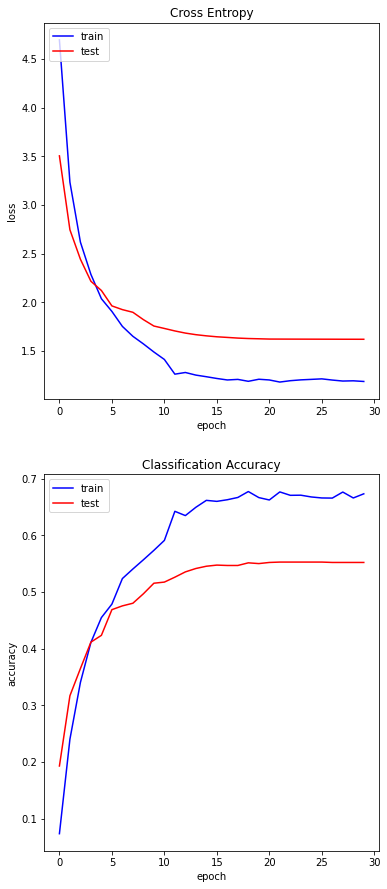

In [33]:
# Plotting The Curves
plot_curves(history)

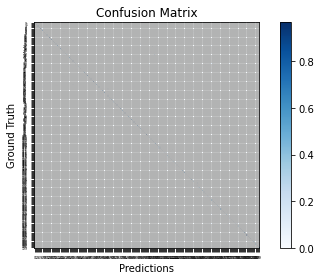

In [34]:
# plot the confusion matrix
plot_confusion_matrix(y_actual, y_pred, classes=targets, normalize='pred')

**Fine-Tuning**

Fine-tuning is defined as a process which unfreezes the entire model or part of it and retrain it on the new data with a very low learning rate. Therefore, we tried fine tune 50, 100, 250 and 300 layers of our model which makes 300 can achieve 55% in this case. 

In [35]:
# Creating the model
# This function defines our neural network:

# FINE TUNING:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 300
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

# The model optimises cross entropy as its loss function and will monitor classification accuracy:
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics='accuracy')

# len(model.trainable_variables)
    
print(model.summary())

Number of layers in the base model:  315
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                  

In [37]:
fine_tune_epochs = 10

history_fine = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=30 + fine_tune_epochs,
                    # epochs=30,
                    callbacks=[lr_scheduler, early_stopping],
                    verbose=2,
                    shuffle=True,
                    initial_epoch=history.epoch[-1],
                    validation_data = validation_generator
)

Learning rate:  1e-06
Epoch 30/40
71/71 - 49s - loss: 1.2067 - accuracy: 0.6618 - val_loss: 1.6134 - val_accuracy: 0.5524 - lr: 1.0000e-06 - 49s/epoch - 691ms/step
Learning rate:  1e-06
Epoch 31/40
71/71 - 40s - loss: 1.2278 - accuracy: 0.6603 - val_loss: 1.6168 - val_accuracy: 0.5530 - lr: 1.0000e-06 - 40s/epoch - 566ms/step
Learning rate:  1.0000000000000001e-07
Epoch 32/40
71/71 - 40s - loss: 1.2076 - accuracy: 0.6576 - val_loss: 1.6213 - val_accuracy: 0.5530 - lr: 1.0000e-07 - 40s/epoch - 565ms/step
Learning rate:  1.0000000000000001e-07
Epoch 33/40
71/71 - 40s - loss: 1.2484 - accuracy: 0.6478 - val_loss: 1.6244 - val_accuracy: 0.5510 - lr: 1.0000e-07 - 40s/epoch - 561ms/step
Learning rate:  1.0000000000000001e-07
Epoch 34/40
71/71 - 40s - loss: 1.1990 - accuracy: 0.6699 - val_loss: 1.6263 - val_accuracy: 0.5504 - lr: 1.0000e-07 - 40s/epoch - 566ms/step
Learning rate:  1.0000000000000001e-07
Epoch 35/40
71/71 - 40s - loss: 1.2088 - accuracy: 0.6667 - val_loss: 1.6273 - val_accurac

In [39]:
scores_fine = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

91/91 [==============================] - 39s 423ms/step - loss: 1.6099 - accuracy: 0.5478
evaluate accuracy: 54.88%


In [41]:
pred_fine=model.predict(test_generator)
print("%s%s: %.2f%%" % ("predict ",model.metrics_names[1], pred_fine[0][1]*100))

91/91 [==============================] - 38s 418ms/step
predict accuracy: 65.71%


In [42]:
from array import array

y_pred_fine = np.argmax(pred_fine, axis=1).tolist()
targets = classes['class_label'].tolist()

y_actual = test_generator.classes
y_actual

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_actual, y_pred_fine))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64        30
           1       0.60      0.70      0.65        30
           2       0.47      0.71      0.56        28
           3       0.75      0.90      0.82        30
           4       0.44      0.79      0.56        14
           5       1.00      0.91      0.95        11
           6       0.95      0.87      0.91        23
           7       0.55      0.67      0.60        18
           8       0.33      0.24      0.28        29
           9       0.62      0.60      0.61        30
          10       0.53      0.27      0.36        30
          11       0.56      0.73      0.63        26
          12       0.80      0.53      0.64        30
          13       0.71      0.97      0.82        30
          14       0.71      0.79      0.75        28
          15       0.65      0.86      0.74        28
          16       0.78      0.52      0.62        27
          17       0.81    

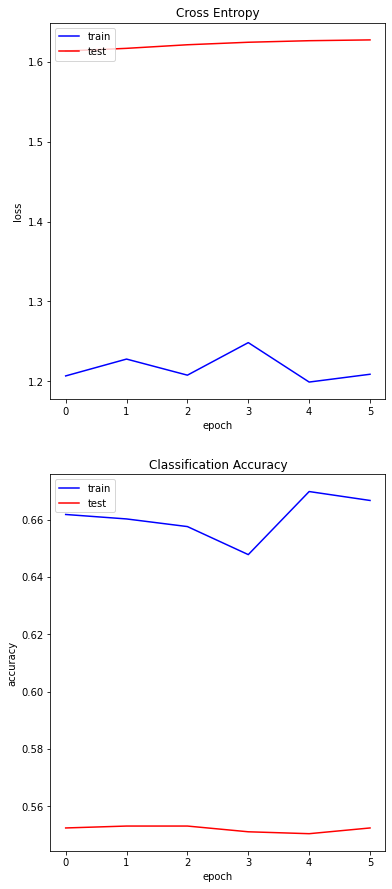

In [44]:
# Plotting The Curves
plot_curves(history_fine)

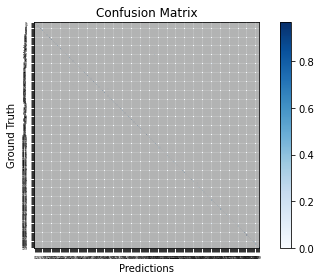

In [45]:
# plot the confusion matrix
plot_confusion_matrix(y_actual, y_pred_fine, classes=targets, normalize='pred')